In [ ]:
# !apt install swig
# !pip install stable-baselines3[extra]

In [ ]:
from google.colab import drive
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
drive.mount('/content/drive/',force_remount=True)
sys.path.insert(0,'/content/drive/MyDrive/BackUp_RL_CodeBase')
os.chdir('/content/drive/MyDrive/BackUp_RL_CodeBase/')
os.getcwd()

Mounted at /content/drive/


'/content/drive/MyDrive/BackUp_RL_CodeBase'

In [ ]:
# specify comparison period, Max range 2003-12-31 : 2021-12-31
start ='2015-12-31' 
end = '2020-12-31'
# result_dir = 'resultsRL/Test20152020/'
result_dir = 'resultsRL/20152020/'

# Load Benchmark results

In [ ]:
from pandas.compat.numpy.function import process_skipna
# 0 read benchmark performance input
raw_eq = pd.read_csv('benchmark_results/EQ.csv',index_col='date')
raw_mc = pd.read_csv('benchmark_results/MC.csv',index_col='date')
raw_gmv = pd.read_csv('benchmark_results/GMV.csv',index_col='date')
raw_msr = pd.read_csv('benchmark_results/MSR.csv',index_col='date')

In [ ]:
# subset datas and align date
def subsetDate(df,start,end):
  df['date'] = df.index
  df = df[(df["date"] >= start) & (df["date"] < end)]
  df = df.drop(columns='date')
  return df

# compute performance
def port_Value(returns, start):
    """
    Takes a timeseries of asset returns
    Computes and returns a Dataframe that contains:
    the wealth index
    the previous peaks
    percent drawdowns
    """
    returns = returns.iloc[:,0]
    wealth_index = start*(1+returns).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({
        "Wealth": wealth_index,
        "Peaks": previous_peaks,
        "Drawdown": drawdowns,
        "Port_return" : returns
    }, index=returns.index)

# subset data
pr_eq = pd.DataFrame(subsetDate(raw_eq,start,end).Port_Return)
pr_mc = pd.DataFrame(subsetDate(raw_mc,start,end).Port_Return)
pr_gmv = pd.DataFrame(subsetDate(raw_gmv,start,end).Port_Return)
pr_msr = pd.DataFrame(subsetDate(raw_msr,start,end).Port_Return)


# Load PPO model Results

In [ ]:
schedule=pd.read_excel("trainingSchedule.xlsx",sheet_name = 'Value',index_col='Id')

In [ ]:
# aggregate In-sample PPO results
for r in range(len(schedule.InSample)):
  # print(r)
  if r == 0:
    filename = f'{schedule.InSample[r]}.csv'
    # print(schedule.InSample[r])
    df_Insample = pd.read_csv(f'{result_dir}{filename}')
  else:
    filename = f'{schedule.InSample[r]}.csv'
    # print(schedule.InSample[r])
    temp = pd.read_csv(f'{result_dir}{filename}')
    df_Insample = df_Insample.append(temp[1:])
# adjust index
df_Insample.index= df_Insample.date

# aggregate Out-of-Sample PPO results
for r in range(len(schedule.OutofSample)):
  # print(r)
  if r == 0:
    filename = f'{schedule.OutofSample[r]}.csv'
    # print(schedule.OutofSample[r])
    df_OutofSample = pd.read_csv(f'{result_dir}{filename}')
  else:
    filename = f'{schedule.OutofSample[r]}.csv'
    # print(schedule.OutofSample[r])
    temp = pd.read_csv(f'{result_dir}{filename}')
    df_OutofSample = df_OutofSample.append(temp[1:])
# adjust index
df_OutofSample.index= df_OutofSample.date


# Long-Term Performance 2015-2020

In [ ]:
# alignment date
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3
intersect = intersection(pr_eq.index, df_Insample.index) # return index intersect

# reindex two sets
pr_eq = pr_eq.loc[intersect]
pr_mc = pr_mc.loc[intersect]
pr_gmv = pr_gmv.loc[intersect]
pr_msr = pr_msr.loc[intersect]

df_Insample = df_Insample.loc[intersect]
df_OutofSample = df_OutofSample.loc[intersect]

# compute performance of two sets
initial_value = 100
eq = port_Value(pr_eq, initial_value)
mc = port_Value(pr_mc, initial_value)
gmv = port_Value(pr_gmv, initial_value)
msr = port_Value(pr_msr, initial_value)

ppo_IS = port_Value(pd.DataFrame(df_Insample.daily_return),initial_value)  
ppo_OS = port_Value(pd.DataFrame(df_OutofSample.daily_return),initial_value)  
  

Text(0.5, 0, 'Date')

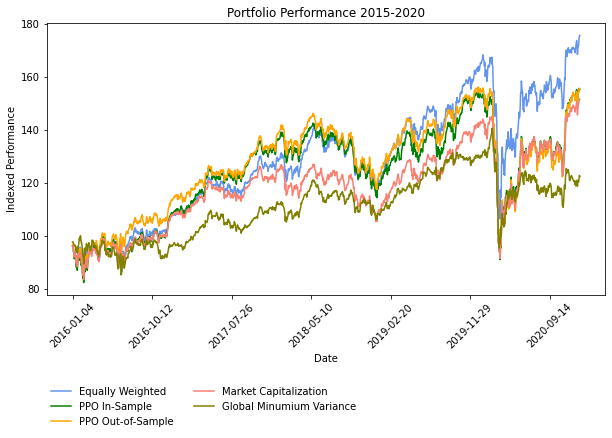

In [ ]:
ax1 = eq.Wealth.plot(color = 'cornflowerblue',label='Equally Weighted',title='Portfolio Performance 2015-2020',figsize =(10,5))
ppo_IS.Wealth.plot(color = 'green',ax=ax1,label = 'PPO In-Sample')
ppo_OS.Wealth.plot(color = 'orange',ax=ax1,label = 'PPO Out-of-Sample')
mc.Wealth.plot(color = 'salmon',ax=ax1,label = 'Market Capitalization')
# msr.Wealth.plot(color='yellow',ax=ax1, label ='Maximum Sharpe Ratio')
gmv.Wealth.plot(color = 'olive',label = 'Global Minumium Variance',ax=ax1,rot=45)
ax1.legend(bbox_to_anchor=(0.0, -0.5, 0.5, 0.5), ncol=2, loc='lower left', 
            borderaxespad=0, frameon=False) 
plt.ylabel('Indexed Performance')
plt.xlabel('Date')

Text(0.5, 0, 'Date')

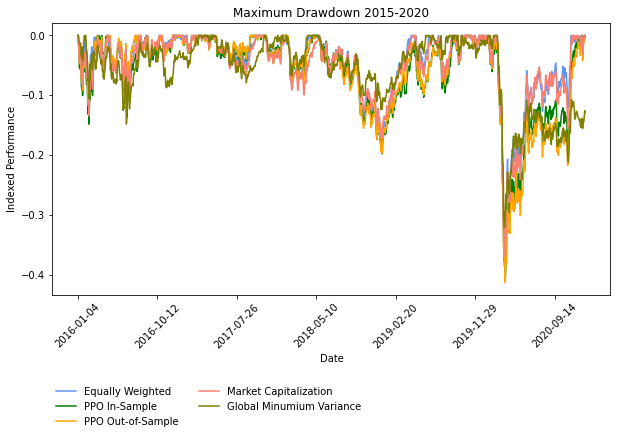

In [ ]:
ax1 = eq.Drawdown.plot(color = 'cornflowerblue',label='Equally Weighted',title='Maximum Drawdown 2015-2020',figsize =(10,5))
ppo_IS.Drawdown.plot(color = 'green',ax=ax1,label = 'PPO In-Sample')
ppo_OS.Drawdown.plot(color = 'orange',ax=ax1,label = 'PPO Out-of-Sample')
mc.Drawdown.plot(color = 'salmon',ax=ax1,label = 'Market Capitalization')
# msr.Drawdown.plot(color='yellow',ax=ax1, label ='Maximum Sharpe Ratio')
gmv.Drawdown.plot(color = 'olive',label = 'Global Minumium Variance',ax=ax1,rot=45).legend(bbox_to_anchor=(1.0, 1.0))
ax1.legend(bbox_to_anchor=(0.0, -0.5, 0.5, 0.5), ncol=2, loc='lower left', 
            borderaxespad=0, frameon=False) 
plt.ylabel('Indexed Performance')
plt.xlabel('Date')

In [ ]:
df_portInd = pd.DataFrame({'PPO_IS':ppo_IS.Wealth/initial_value,
              'PPO_OS':ppo_OS.Wealth/initial_value,
              'MC':mc.Wealth/initial_value,
              'EQ':eq.Wealth/initial_value,
              'GMV':gmv.Wealth/initial_value,
              # 'MSR':msr.Wealth,
              'Year': [date[:4] for date in ppo_IS.index.tolist()] })
# df_portInd

In [ ]:
df_port = pd.DataFrame({'PPO_IS':df_Insample.daily_return,
              'PPO_OS':df_OutofSample.daily_return,
              'MC':pr_mc.Port_Return,
              'EQ':pr_eq.Port_Return,
              'GMV':pr_gmv.Port_Return,
              # 'MSR':pr_msr.Port_Return,
              'Year': [date[:4] for date in df_Insample.index.tolist()] })
# df_port

## Annulized Volatiltiy

In [ ]:
# annulized volatiltiy
pd.options.display.float_format = '{:.5}'.format
df_dailyVol = df_port.groupby(by='Year').std() 
df_period = df_port.groupby(by='Year').count()
annulized_vol = df_dailyVol * np.sqrt(df_period) 
annulized_vol=  np.round(annulized_vol*100,2)
annulized_vol = annulized_vol.transpose()
# Add Average Model
annulized_vol['Model'] = np.round(annulized_vol.mean(axis=1),2)
# Add Average through the year
avg_vol_year = np.round(pd.DataFrame(annulized_vol.mean(axis=0),columns=['Average']).T,2)
annulized_vol = annulized_vol.append(avg_vol_year)
annulized_vol
# annulized_vol.to_latex()

Year,2016,2017,2018,2019,2020,Model
PPO_IS,22.6,11.1,14.71,14.32,34.74,19.49
PPO_OS,20.7,11.14,15.03,14.05,35.47,19.28
MC,20.79,10.04,14.04,13.44,32.36,18.13
EQ,19.11,9.49,15.29,14.21,31.09,17.84
GMV,19.23,8.74,11.52,9.97,25.45,14.98
Average,20.49,10.1,14.12,13.2,31.82,17.94


In [ ]:
# annulized_vol.T.plot.bar()

## Annulized Port Return

In [ ]:
# annulized return
pd.options.display.float_format = '{:.5}'.format
df_dailyAvgR = df_port.groupby(by='Year').mean() 
annulized_return = (1+df_dailyAvgR) ** df_period -1
annulized_return = np.round(annulized_return *100,2)
annulized_return = annulized_return.transpose()
# Add Average Model
annulized_return['Model'] = np.round(annulized_return.mean(axis=1),2)
# Add Average through the year
avg_vol_year = np.round(pd.DataFrame(annulized_return.mean(axis=0),columns=['Average']).T,2)
annulized_return = annulized_return.append(avg_vol_year)
annulized_return
# annulized_return.to_latex()

Year,2016,2017,2018,2019,2020,Model
PPO_IS,11.5,21.84,-10.15,31.51,8.3,12.6
PPO_OS,10.36,16.91,-8.65,29.77,7.36,11.15
MC,10.3,12.44,-10.3,32.58,13.25,11.65
EQ,9.77,17.39,-4.36,37.41,13.78,14.8
GMV,-0.98,13.79,-1.59,20.78,-2.24,5.95
Average,8.19,16.47,-7.01,30.41,8.09,11.23


In [ ]:
targetcol = df_port.columns[:-1]
temp = df_port[targetcol].apply(lambda x:x+1)
temp['Year'] = df_port['Year']
gar=temp.groupby(by='Year').prod()-1
gar=np.round(gar.T*100,2)

# Add Average Model
gar['Model'] = np.round(gar.mean(axis=1),2)
# Add Average through the year
avg_ret_year = np.round(pd.DataFrame(gar.mean(axis=0),columns=['Average']).T,2)
gar = gar.append(avg_ret_year)
# gar.to_latex()
gar

Year,2016,2017,2018,2019,2020,Model
PPO_IS,8.67,21.1,-11.11,30.17,1.92,10.15
PPO_OS,8.01,16.19,-9.67,28.5,0.77,8.76
MC,7.94,11.88,-11.17,31.39,7.42,9.49
EQ,7.78,16.86,-5.47,36.03,8.39,12.72
GMV,-2.81,13.36,-2.24,20.19,-5.4,4.62
Average,5.92,15.88,-7.93,29.26,2.62,9.15


In [ ]:
annulized_return.T.plot.bar()

In [ ]:
pd.concat([annulized_vol,annulized_return], axis=1) # too big

Year,2016,2017,2018,2019,2020,Model,2016,2017,2018,2019,2020,Model
PPO_IS,22.6,11.1,14.71,14.32,34.74,19.49,99.96,99.92,100.04,99.89,99.97,99.96
PPO_OS,20.7,11.14,15.03,14.05,35.47,19.28,99.96,99.94,100.04,99.9,99.97,99.96
MC,20.79,10.04,14.04,13.44,32.36,18.13,99.96,99.95,100.04,99.89,99.95,99.96
EQ,19.11,9.49,15.29,14.21,31.09,17.84,99.96,99.94,100.02,99.88,99.95,99.95
GMV,19.23,8.74,11.52,9.97,25.45,14.98,100.0,99.95,100.01,99.93,100.01,99.98
Average,20.49,10.1,14.12,13.2,31.82,17.94,99.97,99.94,100.03,99.9,99.97,99.96


## Sharpe Ratio

Sharpe Ratio is a risk adjusted return which indicates the risk efficiency, a higher sharpe ratio indicates higher return per unit risk taken. The average sharpe ratio of all models varies strongly through the year, indicates the performance of the portfolios relies strongly on the market movement. The range of the average sharpe ratio falls between -0.5 and 2.3. In the year 2019, the average sharpe ratio of all the models is 2.3. In the year 2018, the lowest average sharpe ratio of -0.5.

In order to compare the models, we have compted the average sharpe ratio based on five year test period. The equally weighted portfolio has the higehst sharpe ratio of 0.83, followed by In sample PPO-based portfolio and Market-cap weighted portoflio. 


In [ ]:
df_SR = np.round(gar/annulized_vol,2)
df_SR

Year,2016,2017,2018,2019,2020,Model
PPO_IS,0.38,1.9,-0.76,2.11,0.06,0.52
PPO_OS,0.39,1.45,-0.64,2.03,0.02,0.45
MC,0.38,1.18,-0.8,2.34,0.23,0.52
EQ,0.41,1.78,-0.36,2.54,0.27,0.71
GMV,-0.15,1.53,-0.19,2.03,-0.21,0.31
Average,0.29,1.57,-0.56,2.22,0.08,0.51


In [ ]:
df_SR.to_latex()

'\\begin{tabular}{lrrrrrr}\n\\toprule\nYear &  2016 &  2017 &  2018 &  2019 &  2020 &  Model \\\\\n\\midrule\nPPO\\_IS  &  0.38 &   1.9 & -0.76 &  2.11 &  0.06 &   0.52 \\\\\nPPO\\_OS  &  0.39 &  1.45 & -0.64 &  2.03 &  0.02 &   0.45 \\\\\nMC      &  0.38 &  1.18 &  -0.8 &  2.34 &  0.23 &   0.52 \\\\\nEQ      &  0.41 &  1.78 & -0.36 &  2.54 &  0.27 &   0.71 \\\\\nGMV     & -0.15 &  1.53 & -0.19 &  2.03 & -0.21 &   0.31 \\\\\nAverage &  0.29 &  1.57 & -0.56 &  2.22 &  0.08 &   0.51 \\\\\n\\bottomrule\n\\end{tabular}\n'

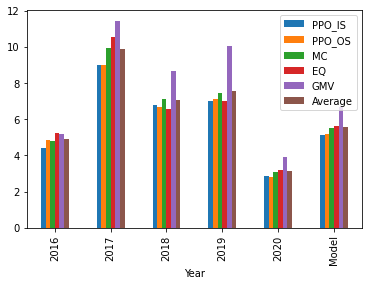

In [ ]:
df_SR.T.plot.bar()

In [ ]:
# gmv_actions.mean(axis=0).sort_values(ascending=False).head()
# mc_actions.mean(axis=0).sort_values(ascending=False).head()
# ppo19IS.mean(axis=0).sort_values(ascending=False).head()
# ppo19OS.mean(axis=0).sort_values(ascending=False).head()

# Random Agent

In [ ]:
# !apt install swig
# !pip install stable-baselines3[extra]

In [ ]:
df=pd.read_pickle("Input/E_cleanInput.pkl")
df=df.sort_values(['tic','date'],ignore_index=True) 

In [ ]:
#small helpers
from helpers.helperFunction import data_split,splitByRatio  

#standard lib
import gym
from gym.utils import seeding
from gym import spaces

from stable_baselines3.common.vec_env import DummyVecEnv,VecNormalize
from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import A2C, DDPG, PPO
from stable_baselines3.common.logger import configure
import torch as th

import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame, input data
        stock_dim : int, number of unique stocks
        initial_amount : int, start capital
        state_space: int, the dimension of input features
        action_space: int, equals stock dimension
        day: int, an increment number to control date
        tech_indicator_list: list, a list of technical indicator names in the dataframe
        transaction_cost_pct: float, transaction cost percentage per trade
        reward_scaling: float, scaling factor for reward, good for training

    Methods
    -------
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                initial_amount,
                transaction_cost_pct,
                state_space,
                action_space,
                lookback=252,
                day = 0):
        super(gym.Env, self).__init__() 
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim  
        self.initial_amount = initial_amount
        self.state_space = state_space
        self.action_space = action_space
        self.terminal = False  
        
        # action space is the number of stock
        self.action_space = spaces.Box(low = 0, high = 10,shape = (self.action_space,)) 
        # observation space is the daily return matrix with one year lookback period
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space,self.stock_dim+1))

        # select remaining data for a given date, and select the return matrix for that day. that will be the state, if we don't add more
        self.data = self.df.loc[self.day,:]
        self.ret = self.data.iloc[0]['ar']
        self.state = self.ret
   
        # book keeper
        # date memory
        self.date_memory=[self.data.date.unique()[0]]
        self.portfolio_value = self.initial_amount
        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [1]
        # self.portfolio_return_memory = [0]
        # eq initialization, could be random if needed.
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]

        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()
            
            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe Ratio: ",sharpe)
            print("=================================")
            
            return self.state, self.reward, self.terminal,{}

        else:
            print("Model actions: ",actions)
            weights = self.softmax_normalization(actions) 
            print("Weights: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.ret = self.data.iloc[0]['ar']
            self.state = self.ret
            
            # debug print
            print(self.day)
            print(self.state)
            # print(f"last day memory: {last_day_memory}")
            # print(f"counter: {self.day}")
            # print(f"current day info: {self.data}")

            # calcualte portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            print(f'portfolio return:{portfolio_return}')
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            print(f'portfolio value:{self.portfolio_value}')
            self.portfolio_value = new_portfolio_value
            print(f"new portfolio value: {new_portfolio_value}")

            #debug print
            # print(f"close value t= {self.day} : {self.data.close.values}")
            # print(f"close value t= {self.day-1} : {last_day_memory.close.values}")
            # print(f" .......")
            # print(f"actions: {actions}")
            # print(f"weights: {weights}")
            # print(f" .......")
            # print(f"portfolio return Type: {type(portfolio_return)}")
            # print(f"portfolio return: {portfolio_return}")
            # print(f"new portfolio value Type: {type(new_portfolio_value)}")
            # print(f"new portfolio value: {new_portfolio_value}")

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value 
            self.reward = new_portfolio_value 
            #print("Step reward: ", self.reward)
            # we change the reward to log portfolio return, so the reward will be additive
            # self.reward = np.round(np.log(1+portfolio_return-0),4)

        return self.state, self.reward, self.terminal, {'weights':weights}

    def reset(self):
        # date and state
        self.terminal = False 
        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.ret = self.data.iloc[0]['ar']
        self.state =self.ret
        print(f'Environment reset. Day: {self.day}, State: {self.state}')

        # bookkeeping
        self.date_memory=[self.data.date.unique()[0]] 
        self.portfolio_value = self.initial_amount
        # self.portfolio_return_memory = [0]
        self.portfolio_return_memory = [1] # using port return
        self.asset_memory = [self.initial_amount]

        #initialize action equally
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        # self.actions_memory=[[1/(self.stock_dim-1)]*(self.stock_dim-1)] # substract 1 as we have day progress bar along the way
        #random initialization at rest
        # ls= np.random.default_rng(seed=0).random((42))
        # self.actions_memory = [(ls/ls.sum()).tolist()]
        # Another test
        # self.actions_memory = initWeight
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output

    
    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=0):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs
    
    def close(self):
      pass


# Bearish market in 2018

## random agent 2018

In [ ]:
s18 = '2017-12-29'
e18 = '2018-12-31'
train = data_split(df, s18,e18) # index resetted

# environment setting
stock_dimension = len(train.tic.unique())
state_space =1 # single input for state representation
env_kwargs = {
    "initial_amount": 1, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension,
    "action_space":stock_dimension,}
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

# define environment
e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)
print( f'action space: {e_train_gym.action_space}, observation_space: {e_train_gym.observation_space}')
# get_attributes(e_train_gym)

#normalize the environment
mon_env = Monitor(e_train_gym,allow_early_resets=False)
env = DummyVecEnv([lambda:mon_env])
e_train_gym = VecNormalize(env)


In [ ]:
nSim =30
# wrapper on the environment, monitor episodic reward while taking random actions
e_train_rnd = StockPortfolioEnv(df = train, **env_kwargs)
e_train_rnd = Monitor(e_train_rnd) # do not log
ls_eps_reward = []
ls_trajectory = {}
# test for 3 times
for i in range(nSim):
  #episodic length
  e_train_rnd.reset()
  done = e_train_rnd.terminal
  e_train_rnd.action_space.np_random.seed(i)
  while not done:
    # e_train_rnd.seed(321)
    r_act = e_train_rnd.action_space.sample()
    obs, reward, done ,info  = e_train_rnd.step(r_act)
    print(f'done:{done}')
  eps_reward = e_train_rnd.get_episode_rewards()
  ls_trajectory[i] = e_train_rnd.save_asset_memory()
ls_eps_reward.append(eps_reward)
print(f'episodic reward:{ls_eps_reward}')
# 2) df daily return simulation
mcSim = ls_trajectory[0] 
mcSim=mcSim.rename(columns = {'daily_return':'sim_0'})
mcSim['sim_'+str(0)].iloc[0] = 0
for m in range(1,nSim):
  mcSim['sim_'+str(m)] = ls_trajectory[m].daily_return
  mcSim['sim_'+str(m)].iloc[0] = 0
# compute index performance
rndAgent = pd.DataFrame()
rndAgent['date'] = mcSim['date']
for m in range(0,nSim):
  rndAgent['simRun_'+str(m)] = (mcSim['sim_'+str(m)]+1).cumprod()
#3) plot simulation, legend(bbox_to_anchor=(1.0, 1.0),ncol=3)
randMean = np.round(rndAgent.mean(axis=1).iloc[-1],4)
randStd = np.round(rndAgent.std(axis=1).iloc[-1],4)
print(f'mean: {randMean}, std: {randStd}')
rndAgent.plot(title=f'Simulation Random Agent {nSim} Times',legend=False)

In [ ]:
print(f'mean: {randMean}, std: {randStd}')
rndAgent.plot(title=f'Simulation Random Agent {nSim} Times',legend=False)

In [ ]:
# Min Max of the Random Agent
rndAgent = rndAgent.set_index(keys='date', drop=True) # reset index
rndMax = rndAgent.idxmax(axis=1)[-1] # return sim with max end return
rndMin = rndAgent.idxmin(axis=1)[-1] # return sim with max end return

## Benchmarks and models

In [ ]:
s18 = '2017-12-29'
e18 = '2018-12-31'

# subset benchmarkes returns
pr_eq = pd.DataFrame(subsetDate(raw_eq,s18,e18).Port_Return)
pr_mc = pd.DataFrame(subsetDate(raw_mc,s18,e18).Port_Return)
pr_gmv = pd.DataFrame(subsetDate(raw_gmv,s18,e18).Port_Return)
pr_msr = pd.DataFrame(subsetDate(raw_msr,s18,e18).Port_Return)

# alignment date using subseted benchmarket returns
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3
intersect = intersection(pr_eq.index, df_Insample.index) # return index intersect

# reindex two sets
pr_eq = pr_eq.loc[intersect]
pr_mc = pr_mc.loc[intersect]
pr_gmv = pr_gmv.loc[intersect]
pr_msr = pr_msr.loc[intersect]
df_Insample2018 = df_Insample.loc[intersect]
df_OutofSample2018 = df_OutofSample.loc[intersect]

# compute performance of two sets
initial_value = 100
eq = port_Value(pr_eq, initial_value)
mc = port_Value(pr_mc, initial_value)
gmv = port_Value(pr_gmv, initial_value)
msr = port_Value(pr_msr, initial_value)
ppo_IS2018 = port_Value(pd.DataFrame(df_Insample2018.daily_return),initial_value)  
ppo_OS2018 = port_Value(pd.DataFrame(df_OutofSample2018.daily_return),initial_value)  
  

## Performance chart

In [ ]:
ax1 = eq.Wealth.plot(color = 'cornflowerblue',label='Equally Weighted',title='Portfolio Performance 2018',figsize =(10,5))
ppo_IS2018.Wealth.plot(color = 'green',ax=ax1,label = 'PPO In-Sample')
ppo_OS2018.Wealth.plot(color = 'orange',ax=ax1,label = 'PPO Out-of-Sample')
mc.Wealth.plot(color = 'salmon',ax=ax1,label = 'Market Capitalization')
# msr.Wealth.plot(color='yellow',ax=ax1, label ='Maximum Sharpe Ratio')
gmv.Wealth.plot(color = 'olive',label = 'Global Minumium Variance',ax=ax1,rot=45)
#random agent
(rndAgent[rndMax]*100).plot(label='Simulation Random Agent Maximum',legend=True,ax=ax1,color ='thistle')
(rndAgent[rndMin]*100).plot(label='Simulation Random Agent Minimum',legend=True,ax=ax1,color='thistle')


ax1.legend(bbox_to_anchor=(0.0, -0.5, 0.5, 0.5), ncol=2, loc='lower left', 
            borderaxespad=0, frameon=False) 
plt.ylabel('Indexed Performance')
plt.xlabel('Date')

In [ ]:
ax1 = eq.Drawdown.plot(color = 'cornflowerblue',label='Equally Weighted',title='Maximum DrawDown 2018',figsize =(10,5))
ppo_IS2018.Drawdown.plot(color = 'green',ax=ax1,label = 'PPO In-Sample')
ppo_OS2018.Drawdown.plot(color = 'orange',ax=ax1,label = 'PPO Out-of-Sample')
mc.Drawdown.plot(color = 'salmon',ax=ax1,label = 'Market Capitalization')
# msr.Wealth.plot(color='yellow',ax=ax1, label ='Maximum Sharpe Ratio')
gmv.Drawdown.plot(color = 'olive',label = 'Global Minumium Variance',ax=ax1,rot=45)
ax1.legend(bbox_to_anchor=(0.0, -0.5, 0.5, 0.5), ncol=2, loc='lower left', 
            borderaxespad=0, frameon=False) 
plt.ylabel('Indexed Performance')
plt.xlabel('Date')

# Bullish Market 2019

## random agent 2019

In [ ]:
s19 = '2018-12-31'
e19 = '2019-12-31'
train = data_split(df, s19,e19) # index resetted

# environment setting
stock_dimension = len(train.tic.unique())
state_space =1 # single input for state representation
env_kwargs = {
    "initial_amount": 1, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension,
    "action_space":stock_dimension,}
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

# define environment
e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)
print( f'action space: {e_train_gym.action_space}, observation_space: {e_train_gym.observation_space}')
# get_attributes(e_train_gym)

#normalize the environment
mon_env = Monitor(e_train_gym,allow_early_resets=False)
env = DummyVecEnv([lambda:mon_env])
e_train_gym = VecNormalize(env)


In [ ]:
nSim =30
# wrapper on the environment, monitor episodic reward while taking random actions
e_train_rnd = StockPortfolioEnv(df = train, **env_kwargs)
e_train_rnd = Monitor(e_train_rnd) # do not log
ls_eps_reward = []
ls_trajectory = {}
# test for 3 times
for i in range(nSim):
  #episodic length
  e_train_rnd.reset()
  done = e_train_rnd.terminal
  e_train_rnd.action_space.np_random.seed(i)
  while not done:
    # e_train_rnd.seed(321)
    r_act = e_train_rnd.action_space.sample()
    obs, reward, done ,info  = e_train_rnd.step(r_act)
    print(f'done:{done}')
  eps_reward = e_train_rnd.get_episode_rewards()
  ls_trajectory[i] = e_train_rnd.save_asset_memory()
ls_eps_reward.append(eps_reward)
print(f'episodic reward:{ls_eps_reward}')
# 2) df daily return simulation
mcSim = ls_trajectory[0] 
mcSim=mcSim.rename(columns = {'daily_return':'sim_0'})
mcSim['sim_'+str(0)].iloc[0] = 0
for m in range(1,nSim):
  mcSim['sim_'+str(m)] = ls_trajectory[m].daily_return
  mcSim['sim_'+str(m)].iloc[0] = 0
# compute index performance
rndAgent = pd.DataFrame()
rndAgent['date'] = mcSim['date']
for m in range(0,nSim):
  rndAgent['simRun_'+str(m)] = (mcSim['sim_'+str(m)]+1).cumprod()
#3) plot simulation, legend(bbox_to_anchor=(1.0, 1.0),ncol=3)
randMean = np.round(rndAgent.mean(axis=1).iloc[-1],4)
randStd = np.round(rndAgent.std(axis=1).iloc[-1],4)
print(f'mean: {randMean}, std: {randStd}')
rndAgent.plot(title=f'Simulation Random Agent {nSim} Times',legend=False)

In [ ]:
# Min Max of the Random Agent
rndAgent = rndAgent.set_index(keys='date', drop=True) # reset index
rndMax = rndAgent.idxmax(axis=1)[-1] # return sim with max end return
rndMin = rndAgent.idxmin(axis=1)[-1] # return sim with max end return

## Benchmarks and models

In [ ]:
s19 = '2018-12-31'
e19 =	'2019-12-31'

# subset benchmarkes returns
pr_eq = pd.DataFrame(subsetDate(raw_eq,s19,e19).Port_Return)
pr_mc = pd.DataFrame(subsetDate(raw_mc,s19,e19).Port_Return)
pr_gmv = pd.DataFrame(subsetDate(raw_gmv,s19,e19).Port_Return)
pr_msr = pd.DataFrame(subsetDate(raw_msr,s19,e19).Port_Return)

# alignment date using subseted benchmarket returns
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3
intersect = intersection(pr_eq.index, df_Insample.index) # return index intersect

# reindex two sets
pr_eq = pr_eq.loc[intersect]
pr_mc = pr_mc.loc[intersect]
pr_gmv = pr_gmv.loc[intersect]
pr_msr = pr_msr.loc[intersect]
df_Insample2019 = df_Insample.loc[intersect]
df_OutofSample2019 = df_OutofSample.loc[intersect]

# compute performance of two sets
initial_value = 100
eq = port_Value(pr_eq, initial_value)
mc = port_Value(pr_mc, initial_value)
gmv = port_Value(pr_gmv, initial_value)
msr = port_Value(pr_msr, initial_value)
ppo_IS2019 = port_Value(pd.DataFrame(df_Insample2019.daily_return),initial_value)  
ppo_OS2019 = port_Value(pd.DataFrame(df_OutofSample2019.daily_return),initial_value)  
  

## Performance chart

In [ ]:
ax1 = eq.Wealth.plot(color = 'cornflowerblue',label='Equally Weighted',title='Portfolio Performance 2019',figsize =(10,5))
ppo_IS2019.Wealth.plot(color = 'green',ax=ax1,label = 'PPO In-Sample')
ppo_OS2019.Wealth.plot(color = 'orange',ax=ax1,label = 'PPO Out-of-Sample')
mc.Wealth.plot(color = 'salmon',ax=ax1,label = 'Market Capitalization')
# msr.Wealth.plot(color='yellow',ax=ax1, label ='Maximum Sharpe Ratio')

#random agent
(rndAgent[rndMax]*100).plot(label='Simulation Random Agent Maximum',legend=True,ax=ax1,color ='thistle')
(rndAgent[rndMin]*100).plot(label='Simulation Random Agent Minimum',legend=True,ax=ax1,color='thistle')


gmv.Wealth.plot(color = 'olive',label = 'Global Minumium Variance',ax=ax1,rot=45)
ax1.legend(bbox_to_anchor=(0.0, -0.5, 0.5, 0.5), ncol=2, loc='lower left', 
            borderaxespad=0, frameon=False) 
plt.ylabel('Indexed Performance')
plt.xlabel('Date')

## Allocation

In [ ]:
# weight is not cleaned yet
# msr_wgt = pd.read_csv('benchmark_results/wgt_msr.csv',index_col ='date')
gmv_weight = pd.read_csv('benchmark_results/wgt_gmv.csv',index_col ='date')
mc_wgt = pd.read_csv('benchmark_results/wgt_mc.csv',index_col ='date')

# subset weights
# msr_actions = subsetDate(msr_wgt)
gmv_actions = subsetDate(gmv_weight,s19,e19)
mc_actions = subsetDate(mc_wgt,s19,e19)

In [ ]:
# list_date = msr_actions.index.tolist()
# xtic = [list_date[i] for i in range(0,len(list_date),50)]#tic
# msr_actions.plot.bar(title ='Allocation MSR Portfolio',figsize=(10,6),stacked=True).legend(bbox_to_anchor=(1.0, 1.0),ncol=3)
# plt.xticks(ticks =np.arange(0,len(list_date),step=50),labels=xtic,rotation=True) 
# plt.show()

In [ ]:
# msr_actions.iloc[0].sort_values(ascending=False)

In [ ]:
list_date = gmv_actions.index.tolist()
xtic = [list_date[i] for i in range(0,len(list_date),50)]#tic
gmv_actions.plot.bar(title ='Allocation GMV Portfolio',figsize=(10,6),stacked=True).legend(bbox_to_anchor=(1.0, 1.0),ncol=2)
plt.xticks(ticks =np.arange(0,len(list_date),step=50),labels=xtic,rotation=True) 
plt.show()

In [ ]:
gmv_actions.mean(axis=0).sort_values(ascending=False).head()

In [ ]:
list_date = mc_actions.index.tolist()
xtic = [list_date[i] for i in range(0,len(list_date),50)]#tic
mc_actions.plot.bar(title ='Allocation MC Portfolio',figsize=(10,6),stacked=True).legend(bbox_to_anchor=(1.0, 1.0),ncol=2)
plt.xticks(ticks =np.arange(0,len(list_date),step=50),labels=xtic,rotation=True) 
plt.show()

In [ ]:
# gmv_actions.mean(axis=0).sort_values(ascending=False).head()
mc_actions.mean(axis=0).sort_values(ascending=False).head()

In [ ]:
ppo19IS = pd.read_csv('resultsRL/20152020/PPO_4_InSample1819A.csv',index_col='date')
ppo19OS = pd.read_csv('resultsRL/20152020/PPO_3_OutofSample1819A.csv',index_col='date')

In [ ]:
list_date = ppo19IS.index.tolist()
xtic = [list_date[i] for i in range(0,len(list_date),50)]#tic
ppo19IS.plot.bar(title ='Allocation PPO Portfolio In-Sample 2019',figsize=(10,6),stacked=True).legend(bbox_to_anchor=(1.0, 1.0),ncol=2)
plt.xticks(ticks =np.arange(0,len(list_date),step=50),labels=xtic,rotation=True) 
plt.show()

In [ ]:
# gmv_actions.mean(axis=0).sort_values(ascending=False).head()
# mc_actions.mean(axis=0).sort_values(ascending=False).head()
ppo19IS.mean(axis=0).sort_values(ascending=False).head()

In [ ]:
list_date = ppo19OS.index.tolist()
xtic = [list_date[i] for i in range(0,len(list_date),50)]#tic
ppo19OS.plot.bar(title ='Allocation PPO Portfolio Out-of-Sample 2019',figsize=(10,6),stacked=True).legend(bbox_to_anchor=(1.0, 1.0),ncol=2)
plt.xticks(ticks =np.arange(0,len(list_date),step=50),labels=xtic,rotation=True) 
plt.show()

#Market Crash 2020

In [ ]:
s18 = '2019-12-29'
e18 = '2020-12-31'

# subset benchmarkes returns
pr_eq = pd.DataFrame(subsetDate(raw_eq,s18,e18).Port_Return)
pr_mc = pd.DataFrame(subsetDate(raw_mc,s18,e18).Port_Return)
pr_gmv = pd.DataFrame(subsetDate(raw_gmv,s18,e18).Port_Return)
pr_msr = pd.DataFrame(subsetDate(raw_msr,s18,e18).Port_Return)

# alignment date using subseted benchmarket returns
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3
intersect = intersection(pr_eq.index, df_Insample.index) # return index intersect

# reindex two sets
pr_eq = pr_eq.loc[intersect]
pr_mc = pr_mc.loc[intersect]
pr_gmv = pr_gmv.loc[intersect]
pr_msr = pr_msr.loc[intersect]
df_Insample2018 = df_Insample.loc[intersect]
df_OutofSample2018 = df_OutofSample.loc[intersect]

# compute performance of two sets
initial_value = 100
eq = port_Value(pr_eq, initial_value)
mc = port_Value(pr_mc, initial_value)
gmv = port_Value(pr_gmv, initial_value)
msr = port_Value(pr_msr, initial_value)
ppo_IS2018 = port_Value(pd.DataFrame(df_Insample2018.daily_return),initial_value)  
ppo_OS2018 = port_Value(pd.DataFrame(df_OutofSample2018.daily_return),initial_value)  
  

In [ ]:
ax1 = eq.Wealth.plot(color = 'cornflowerblue',label='Equally Weighted',title='Portfolio Performance 2019',figsize =(10,5))
ppo_IS2018.Wealth.plot(color = 'green',ax=ax1,label = 'PPO In-Sample')
ppo_OS2018.Wealth.plot(color = 'orange',ax=ax1,label = 'PPO Out-of-Sample')
mc.Wealth.plot(color = 'salmon',ax=ax1,label = 'Market Capitalization')
# msr.Wealth.plot(color='yellow',ax=ax1, label ='Maximum Sharpe Ratio')
gmv.Wealth.plot(color = 'olive',label = 'Global Minumium Variance',ax=ax1,rot=45)
ax1.legend(bbox_to_anchor=(0.0, -0.5, 0.5, 0.5), ncol=2, loc='lower left', 
            borderaxespad=0, frameon=False) 
plt.ylabel('Indexed Performance')
plt.xlabel('Date')